In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from itertools import combinations

In [2]:
df = pd.read_csv('stud_math.csv')

Вспомогательные функции:

In [3]:
# пустую строку или NaN меняем на None (функция для строковых данных)
def clearNaN(val):
    if val.strip() in ['', 'nan']:
        return None
    return val

# функция возвращающая 1-ый квартиль(0.25)
def getQ1(data, column):
    return data[column].quantile(0.25)

# функция возвращающая 3-ий квартиль(0.75)
def getQ3(data, column):
    return data[column].quantile(0.75)

# левая граница (все что левее - выброс)
def getLeftOutlierBorder(data, column):
    q1 = getQ1(data, column)
    q3 = getQ3(data, column)
    iqr = q3 - q1
    return q1 - 1.5*iqr

# правая граница (все что правее - выброс)
def getRightOutlierBorder(data, column):
    q1 = getQ1(data, column)
    q3 = getQ3(data, column)
    iqr = q3 - q1
    return q3 + 1.5*iqr

# проверяем есть ли выбросы слева
def isLeftQutlier(data, column):
    lb = getLeftOutlierBorder(data, column)
    return data[data[column] < lb][column].count() > 0

# проверяем есть ли выбросы справа
def isRightQutlier(data, column):
    rb = getRightOutlierBorder(data, column)
    return data[data[column] > rb][column].count() > 0

# функция для создания графиков для номинативных переменных
def get_boxplot(data, column, ev_field):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y=ev_field,
                data=data.loc[data.loc[:, column].isin(
                    data.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

# поиск статистически значемых различий для колонок
def get_stat_dif(data, column, ev_field):
    cols = data.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], ev_field],
                     data.loc[data.loc[:, column] == comb[1], ev_field]).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

# Отображение уникальных значений и также количества нулевых значений для столблцов. Используется при проверке значений после преобразований
def showData():
    for column in df.columns:
        print('{}: Значения: {}. Кол-во нулевых значений - {}'.format(column, df[column].unique(),
                                                                      (df[column].isnull().sum())))

Шаг 1. Выводим уникальные значения по каждому из столбцов, чтобы бегло осмотреть данные (так как значения в столбцах повторяющиеся и нет таких уникальных показателей как id или имя, кол-во значений будет ограничено и их можно просмотреть).

In [4]:
showData()
df.info()

school: Значения: ['GP' 'MS']. Кол-во нулевых значений - 0
sex: Значения: ['F' 'M']. Кол-во нулевых значений - 0
age: Значения: [18 17 15 16 19 22 20 21]. Кол-во нулевых значений - 0
address: Значения: ['U' nan 'R']. Кол-во нулевых значений - 17
famsize: Значения: [nan 'GT3' 'LE3']. Кол-во нулевых значений - 27
Pstatus: Значения: ['A' nan 'T']. Кол-во нулевых значений - 45
Medu: Значения: [ 4.  1.  3.  2. nan  0.]. Кол-во нулевых значений - 3
Fedu: Значения: [ 4.  1.  2.  3. 40. nan  0.]. Кол-во нулевых значений - 24
Mjob: Значения: ['at_home' 'health' 'other' 'services' 'teacher' nan]. Кол-во нулевых значений - 19
Fjob: Значения: ['teacher' 'other' nan 'health' 'services' 'at_home']. Кол-во нулевых значений - 36
reason: Значения: ['course' 'other' 'home' 'reputation' nan]. Кол-во нулевых значений - 17
guardian: Значения: ['mother' 'father' 'other' nan]. Кол-во нулевых значений - 31
traveltime: Значения: [ 2.  1.  3. nan  4.]. Кол-во нулевых значений - 28
studytime: Значения: [ 2.  3. 

По данным выше можно сделать вывод, что пустых строковых ('') значениц нет, но есть nan в ряде строковых элементов. Так как NaN это числовое значение, то лучше заменять его на None для нечисловых значений. 
Шаг 2. Применяем функцию преобразования ко всем столбцам. 

In [5]:
for column in df.columns:
    if df[column].dtype == 'object' and df[column].isnull().values.any():
        df[column] = df[column].astype(str).apply(clearNaN)

Результат после обработки:

In [6]:
showData()
df.info()

school: Значения: ['GP' 'MS']. Кол-во нулевых значений - 0
sex: Значения: ['F' 'M']. Кол-во нулевых значений - 0
age: Значения: [18 17 15 16 19 22 20 21]. Кол-во нулевых значений - 0
address: Значения: ['U' None 'R']. Кол-во нулевых значений - 17
famsize: Значения: [None 'GT3' 'LE3']. Кол-во нулевых значений - 27
Pstatus: Значения: ['A' None 'T']. Кол-во нулевых значений - 45
Medu: Значения: [ 4.  1.  3.  2. nan  0.]. Кол-во нулевых значений - 3
Fedu: Значения: [ 4.  1.  2.  3. 40. nan  0.]. Кол-во нулевых значений - 24
Mjob: Значения: ['at_home' 'health' 'other' 'services' 'teacher' None]. Кол-во нулевых значений - 19
Fjob: Значения: ['teacher' 'other' None 'health' 'services' 'at_home']. Кол-во нулевых значений - 36
reason: Значения: ['course' 'other' 'home' 'reputation' None]. Кол-во нулевых значений - 17
guardian: Значения: ['mother' 'father' 'other' None]. Кол-во нулевых значений - 31
traveltime: Значения: [ 2.  1.  3. nan  4.]. Кол-во нулевых значений - 28
studytime: Значения: [ 

Шаг 3. Проверим выборосы по количественным числовым переменным. 
Берем столблцы age, absences, score. 

In [8]:
# двигаемся по всем колонкам. Если колонка попадает в список отобранных для проверки на выборосы, то производим проверку.

for column in ['age', 'absences', 'score']:
    # если есть левые выброcы, оставляем то, что справа
    if isLeftQutlier(df, column):
        lbn = getLeftOutlierBorder(df, column)
        df = df.loc[df[column] >= lbn]
    # если есть правые выброcы, оставляем то, что слева
    if isRightQutlier(df, column):
        rbn = getRightOutlierBorder(df, column)
        df = df.loc[df[column] <= rbn]

Данные после обработки выбросов

In [9]:
showData()
df.info()

school: Значения: ['GP' 'MS']. Кол-во нулевых значений - 0
sex: Значения: ['F' 'M']. Кол-во нулевых значений - 0
age: Значения: [18 17 15 16 19 20 21]. Кол-во нулевых значений - 0
address: Значения: ['U' None 'R']. Кол-во нулевых значений - 13
famsize: Значения: [None 'GT3' 'LE3']. Кол-во нулевых значений - 18
Pstatus: Значения: ['A' None 'T']. Кол-во нулевых значений - 33
Medu: Значения: [ 4.  1.  3.  2. nan  0.]. Кол-во нулевых значений - 2
Fedu: Значения: [ 4.  1.  2.  3. 40. nan  0.]. Кол-во нулевых значений - 19
Mjob: Значения: ['at_home' 'health' 'other' 'services' 'teacher' None]. Кол-во нулевых значений - 14
Fjob: Значения: ['teacher' 'other' None 'health' 'services' 'at_home']. Кол-во нулевых значений - 28
reason: Значения: ['course' 'other' 'home' 'reputation' None]. Кол-во нулевых значений - 15
guardian: Значения: ['mother' 'father' 'other' None]. Кол-во нулевых значений - 28
traveltime: Значения: [ 2.  1.  3. nan  4.]. Кол-во нулевых значений - 22
studytime: Значения: [ 2. 

Шаг 4. Количество уникальных значений для номинативных переменных
Для начала перечислим список столбцов, которые считаем номинативными и далее выведем по ним кол-во уникальных значений и список уникальных значений. 


In [10]:
nom_columns = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian',
               'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'studytime, granular',
               'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health']
for column in nom_columns:
    print('{}: ({} уникальных значения) - {})'.format(column,
                                                      df[column].nunique(), df[column].unique()))

school: (2 уникальных значения) - ['GP' 'MS'])
sex: (2 уникальных значения) - ['F' 'M'])
address: (2 уникальных значения) - ['U' None 'R'])
famsize: (2 уникальных значения) - [None 'GT3' 'LE3'])
Pstatus: (2 уникальных значения) - ['A' None 'T'])
Medu: (5 уникальных значения) - [ 4.  1.  3.  2. nan  0.])
Fedu: (6 уникальных значения) - [ 4.  1.  2.  3. 40. nan  0.])
Mjob: (5 уникальных значения) - ['at_home' 'health' 'other' 'services' 'teacher' None])
Fjob: (5 уникальных значения) - ['teacher' 'other' None 'health' 'services' 'at_home'])
reason: (4 уникальных значения) - ['course' 'other' 'home' 'reputation' None])
guardian: (3 уникальных значения) - ['mother' 'father' 'other' None])
traveltime: (4 уникальных значения) - [ 2.  1.  3. nan  4.])
studytime: (4 уникальных значения) - [ 2.  3.  1. nan  4.])
failures: (4 уникальных значения) - [ 0.  3. nan  2.  1.])
schoolsup: (2 уникальных значения) - ['yes' 'no' None])
famsup: (2 уникальных значения) - ['no' 'yes' None])
paid: (2 уникальны

Шаг 5. Коррелиационный анализ количественных переменных.

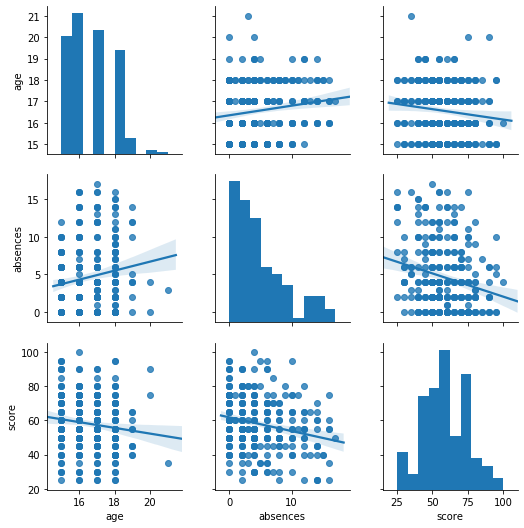

In [11]:
sns.pairplot(df.loc[:, ['age', 'absences', 'score']], kind='reg')

In [12]:
df.loc[:, ['age', 'absences', 'score']].corr()

,age,absences,score
age,1.000000,0.164239,-0.127954
absences,0.164239,1.000000,-0.223133
score,-0.127954,-0.223133,1.000000


Исходя из представленных данных можно сделать следующие выводы:
1) Корреляция между количественными показателями слабая. 
2) С увеличением возвраста сдающих происходит незначительное ухудшение оценок
3) С увеличением количества пропуском происходит незначительное ухудшение оценок
4) Чем старше человек, тем он скорее будет пропускать занятия.  

Шаг 6. Анализ номинативных переменных.


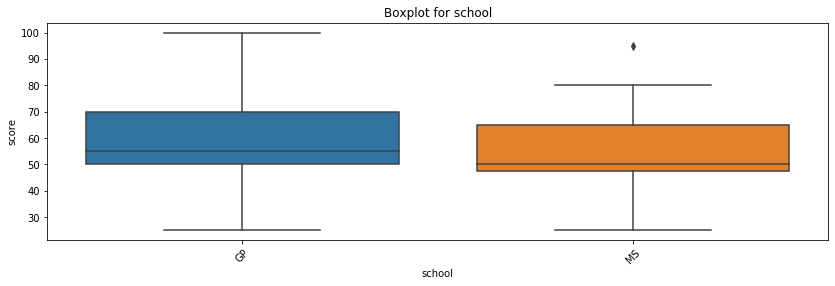

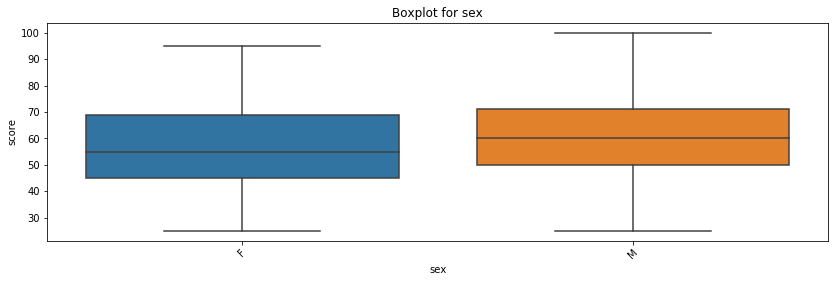

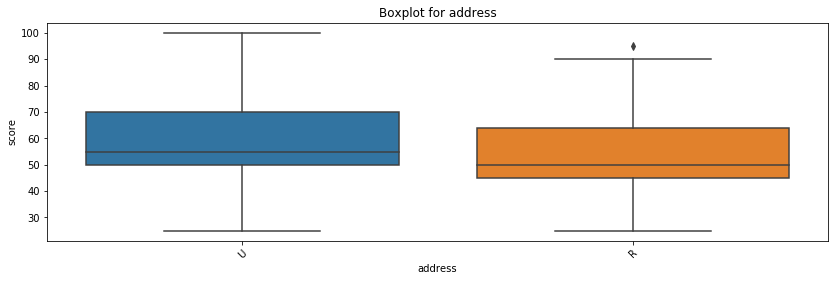

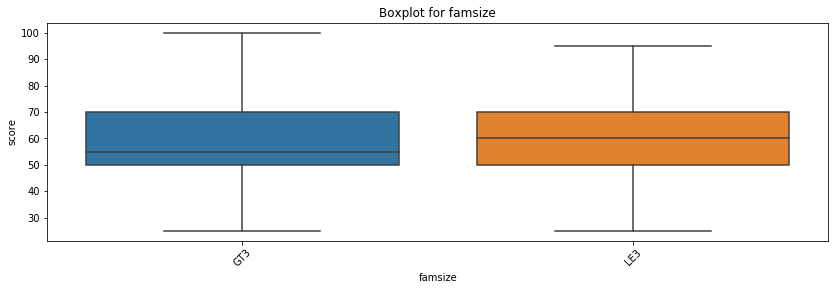

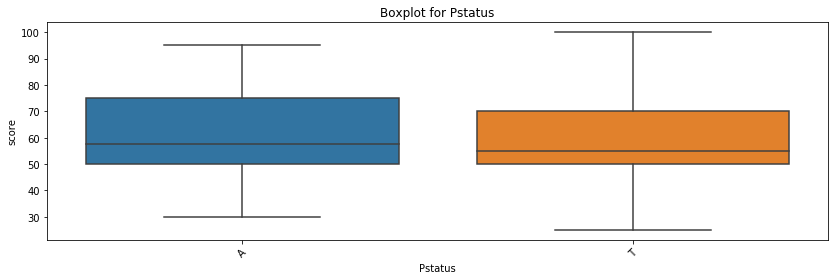

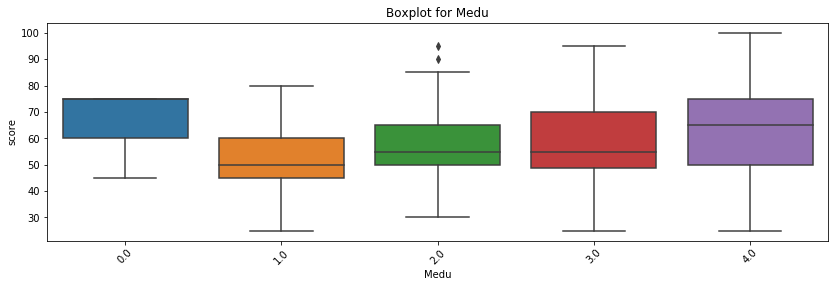

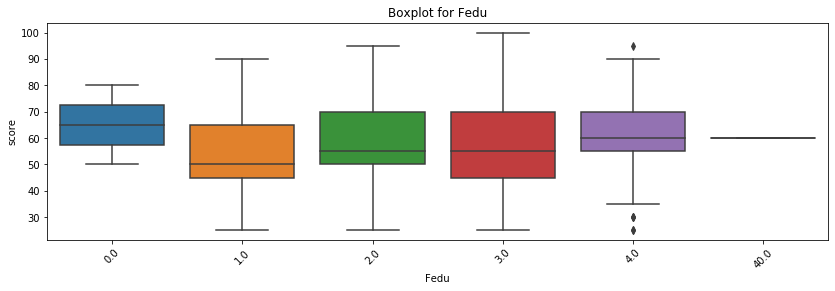

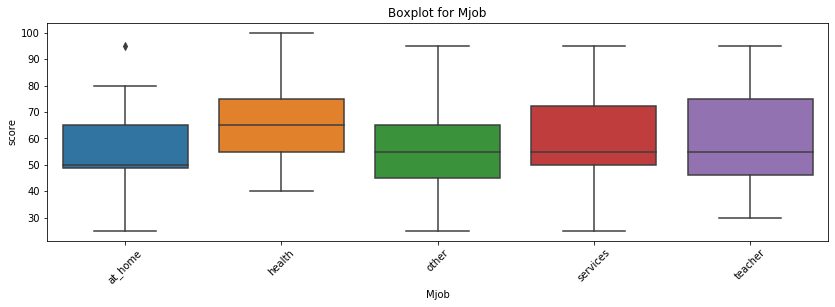

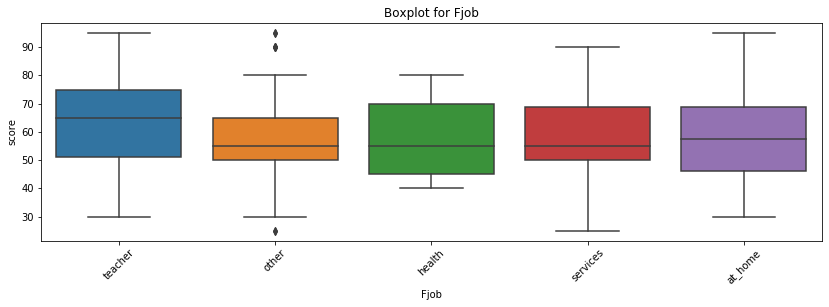

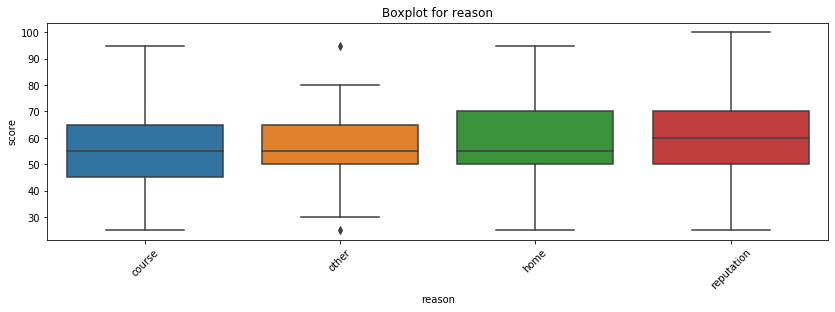

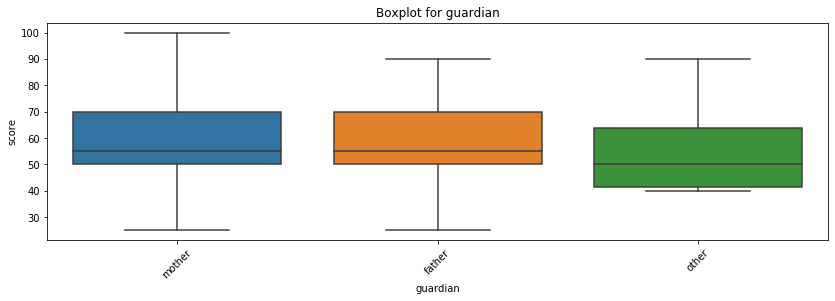

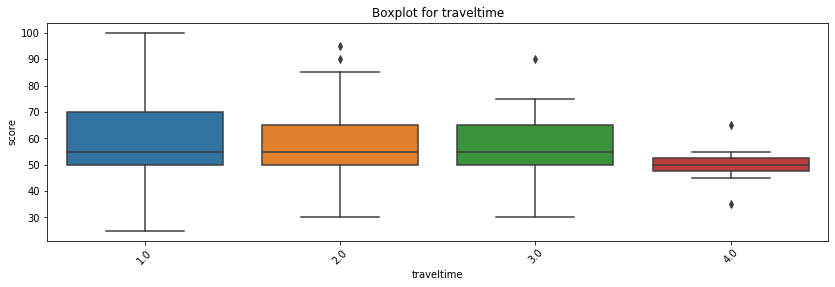

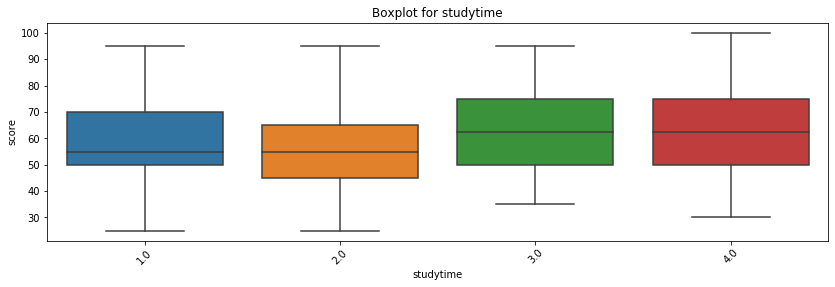

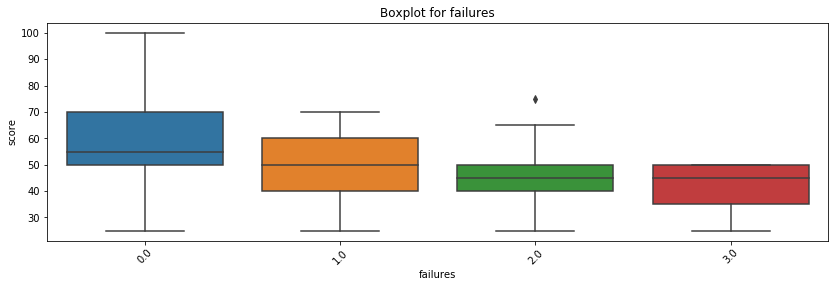

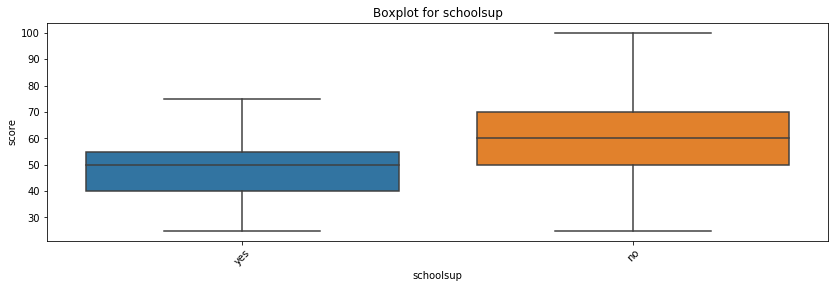

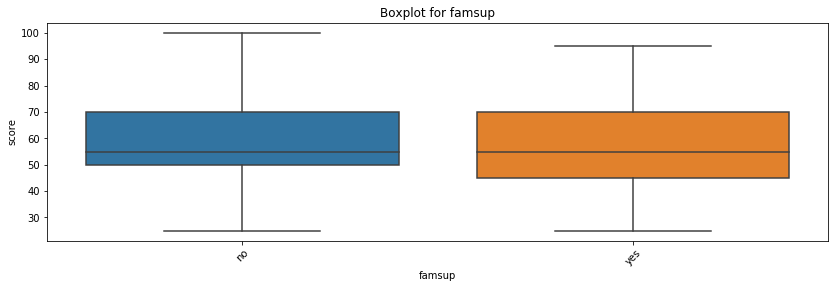

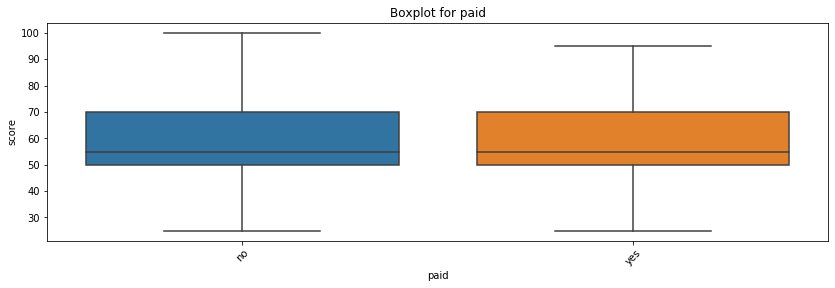

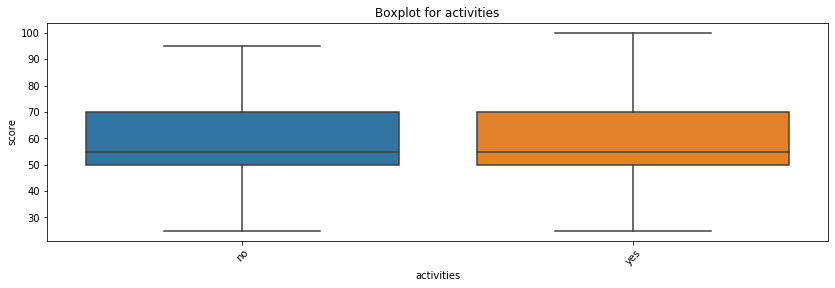

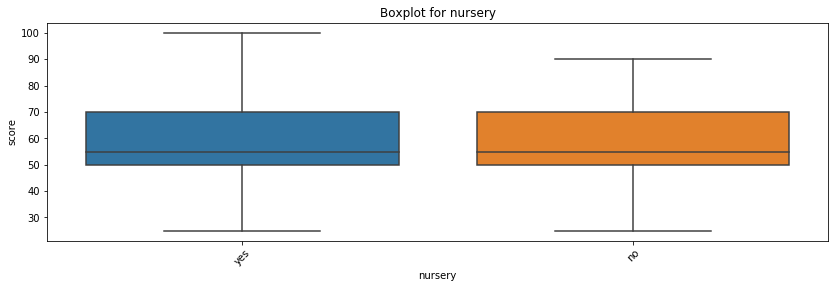

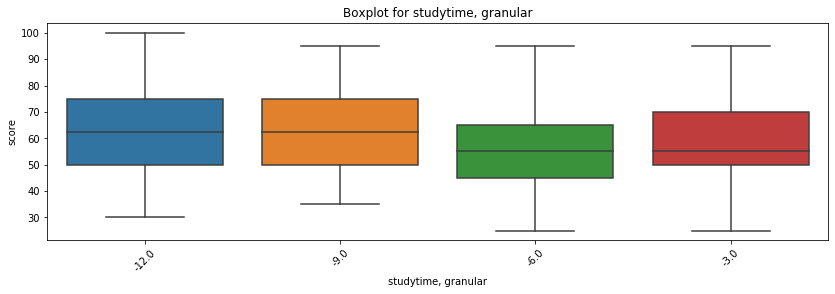

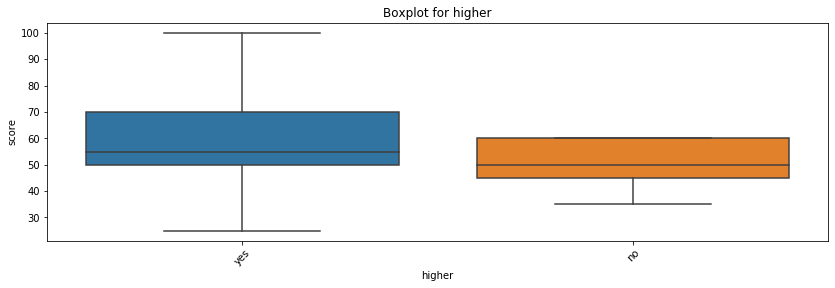

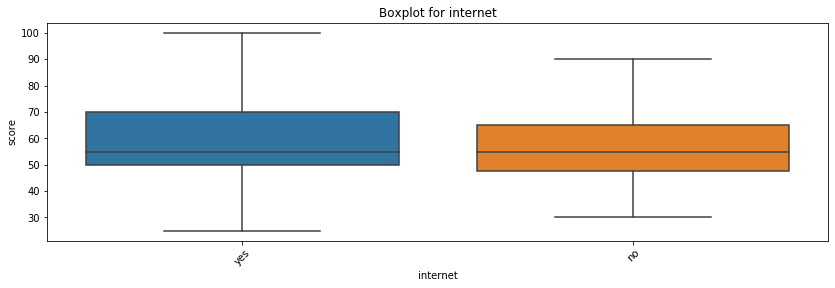

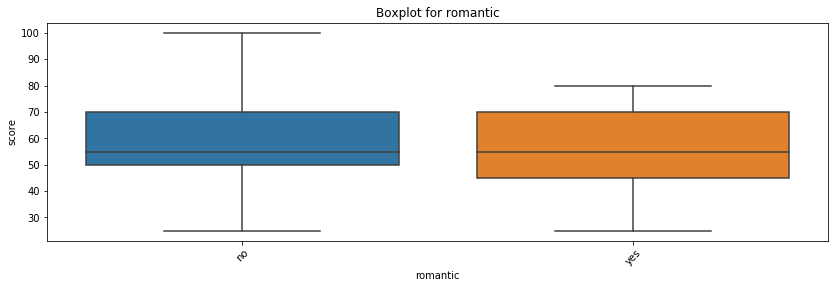

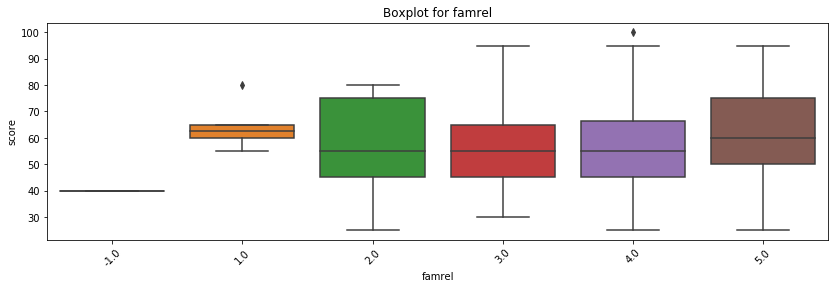

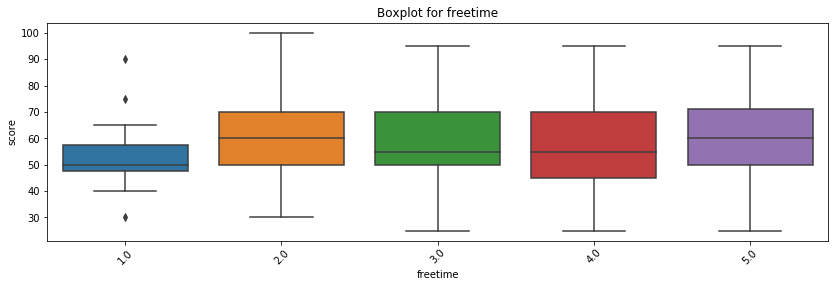

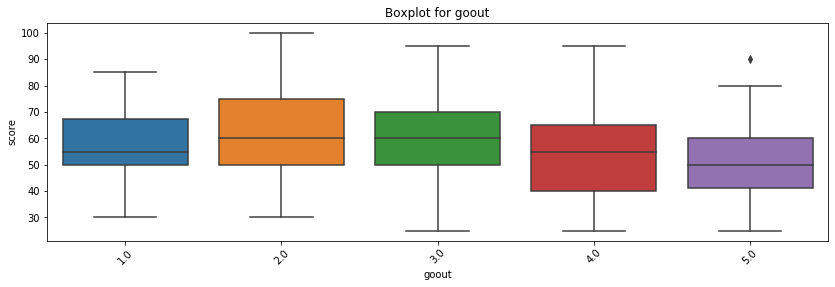

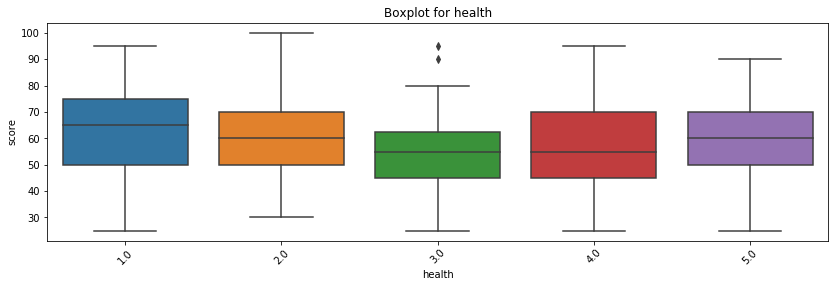

In [13]:
for column in nom_columns:
    get_boxplot(df, column, 'score')

In [15]:
for column in nom_columns:
    get_stat_dif(df,column, 'score')

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки studytime, granular
Найдены статистически значимые различия для колонки goout


Выводы.
Исходя из полученных данных для дальнейшего анализа предложено использовать следующий набор колонок. 
sex, address, Medu, Mjob, studytime, failures, schoolsup, 'stydytime, granular', goout, age, absences, score

Также, несмотря на то, что в вычисления выше не попали колонки Fedu, Fjob, famrel, health - данные колонки также предлагается влкючить, так как исходя из графиков выше, они могут иметь влияние на оценку. 

Финальный список колонок:

In [24]:
df_for_model = df.loc[:,['sex', 'address', 'Medu', 'Mjob' 'Fedu', 'Fjob' 'studytime', 'failures', 
                       'schoolsup', 'studytime, granular',
                       'famrel', 'goout' 'health', 'age', 'absences', 'score']]

In [25]:
df_for_model.head()

,sex,address,Medu,MjobFedu,Fjobstudytime,failures,schoolsup,"studytime, granular",famrel,goouthealth,age,absences,score
0,F,U,4.0,NaN,NaN,0.0,yes,-6.0,4.0,NaN,18,6.0,30.0
1,F,U,1.0,NaN,NaN,0.0,no,-6.0,5.0,NaN,17,4.0,30.0
2,F,U,1.0,NaN,NaN,3.0,yes,-6.0,4.0,NaN,15,10.0,50.0
3,F,U,4.0,NaN,NaN,0.0,no,-9.0,3.0,NaN,15,2.0,75.0
4,F,U,3.0,NaN,NaN,0.0,no,-6.0,4.0,NaN,16,4.0,50.0
